In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
import pandas as pd
from matplotlib.colors import Normalize, ListedColormap, BoundaryNorm
import numpy as np
from matplotlib import cm
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
import math
import geopandas as gpd
from shapely.geometry import box
import os

### Description:
______________
This script reads the skill score csv, and a shapefile path to create plots of BME scores across the CAMELS-SPAT basins.

### Inputs

In [2]:
# -------------------------------
# Load data
skill_scores_long = pd.read_csv('../camels-spat/02_results/skill_scores/nse_skill_scores_rank_001.csv')
output_dir = '../camels-spat/02_results/nse_plots/'
plot_prefix = 'nse'

# -------------------------------
# Settings
period = 'validation'

border_path = '../camels-spat/politicalboundaries_shapefile/NA_PoliticalDivisions/simplified/simplified_boundaries_15km.shp'

In [3]:
# Specify the benchmarks and metrics to calculate
map_plots = [
    # Flow
     "bm_mean_flow", 
    # "bm_median_flow",
    # "bm_monthly_mean_flow", 
    # "bm_monthly_median_flow",
     "bm_daily_mean_flow", 
    # "bm_daily_median_flow", 
    # "bm_eckhardt_baseflow",
    # # RRR
    # "bm_rainfall_runoff_ratio_to_all",
    # "bm_rainfall_runoff_ratio_to_annual",
    # "bm_rainfall_runoff_ratio_to_monthly",
    # "bm_rainfall_runoff_ratio_to_daily",
    # "bm_rainfall_runoff_ratio_to_timestep",
     "bm_monthly_rainfall_runoff_ratio_to_monthly",
    # "bm_monthly_rainfall_runoff_ratio_to_daily",
    # "bm_monthly_rainfall_runoff_ratio_to_timestep",
    # "bm_scaled_precipitation_benchmark",
    # # Precipitation Anomaly
     "bm_scaled_daily_mean_flow",
    # "bm_monthly_scaled_daily_mean_flow",
    # # Parsimonious Models
    # "bm_adjusted_precipitation_benchmark",
     "bm_adjusted_smoothed_precipitation_benchmark",
    # "bm_baseflow_with_event_peaks",
    # "bm_api_scaled_flow",

    # # Summary 
    # 'highest',
     'lowest'
      ]

difference_plots= [
    # Streamflow benchmarks
    "bm_mean_flow",
    'difference'
]

# Specify the benchmarks and metrics to calculate
cdf_plots = [
    # Flow
    "bm_mean_flow", "bm_median_flow",
    "bm_monthly_mean_flow", "bm_monthly_median_flow",
    "bm_daily_mean_flow", "bm_daily_median_flow", "bm_eckhardt_baseflow",
    # RRR
    "bm_rainfall_runoff_ratio_to_all",
    "bm_rainfall_runoff_ratio_to_annual",
    "bm_rainfall_runoff_ratio_to_monthly",
    "bm_rainfall_runoff_ratio_to_daily",
    "bm_rainfall_runoff_ratio_to_timestep",
    "bm_monthly_rainfall_runoff_ratio_to_monthly",
    "bm_monthly_rainfall_runoff_ratio_to_daily",
    "bm_monthly_rainfall_runoff_ratio_to_timestep",
    "bm_scaled_precipitation_benchmark",
    # Precipitation Anomaly
    "bm_scaled_daily_mean_flow",
    "bm_monthly_scaled_daily_mean_flow",
    # Parsimonious Models
    "bm_adjusted_precipitation_benchmark",
    "bm_adjusted_smoothed_precipitation_benchmark",
    "bm_baseflow_with_event_peaks",
    "bm_api_scaled_flow",

    # Summary 
    'highest',
    'lowest'
     ]

### Pre-Processing

In [4]:
# Filter by period
df_period = skill_scores_long[skill_scores_long['period'] == period]

# Function to get value + corresponding benchmark
def get_extreme(df, agg_func='max'):
    if agg_func == 'max':
        idx = df['skill_score'].idxmax()
    else:
        idx = df['skill_score'].idxmin()
    return pd.Series({
        'value': df.loc[idx, 'skill_score'],
        'benchmark': df.loc[idx, 'benchmark']
    })

# Compute highest and lowest per catchment
catchment_extremes = df_period.groupby('catchment', group_keys=False).apply(
    lambda x: pd.concat([
        get_extreme(x, 'max').rename(lambda k: f'highest_{k}'),
        get_extreme(x, 'min').rename(lambda k: f'lowest_{k}')
    ])
).reset_index()

# Merge lat/lon
latlon = df_period[['catchment','latitude','longitude']].drop_duplicates()
catchment_stats = catchment_extremes.merge(latlon, on='catchment', how='left')

/tmp/ipykernel_1066107/873659307.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  catchment_extremes = df_period.groupby('catchment', group_keys=False).apply(


In [5]:
# --- Load borders shapefile once
have_borders = False
if os.path.exists(border_path):
    have_borders = True
    gdf_borders = gpd.read_file(border_path)
    
    # Reproject to EPSG:4326 if needed
    if gdf_borders.crs != "EPSG:4326":
        gdf_borders = gdf_borders.to_crs("EPSG:4326")
    
    map_color = '0.65'

### Spatial Plots

In [6]:
def format_benchmark_name(benchmark_name):
    """Format benchmark names for display with category prefix"""
    categories = {
        'Flow': [
            "bm_mean_flow", "bm_median_flow",
            "bm_monthly_mean_flow", "bm_monthly_median_flow",
            "bm_daily_mean_flow", "bm_daily_median_flow", "bm_eckhardt_baseflow"
        ],
        'Rainfall Runoff': [
            "bm_rainfall_runoff_ratio_to_all",
            "bm_rainfall_runoff_ratio_to_annual",
            "bm_rainfall_runoff_ratio_to_monthly",
            "bm_rainfall_runoff_ratio_to_daily",
            "bm_rainfall_runoff_ratio_to_timestep",
            "bm_monthly_rainfall_runoff_ratio_to_monthly",
            "bm_monthly_rainfall_runoff_ratio_to_daily",
            "bm_monthly_rainfall_runoff_ratio_to_timestep",
            "bm_scaled_precipitation_benchmark",
        ],
        'Precipitation Anomaly': [
            "bm_scaled_daily_mean_flow",
            "bm_monthly_scaled_daily_mean_flow",
        ],
        'Models': [
            "bm_adjusted_precipitation_benchmark",
            "bm_adjusted_smoothed_precipitation_benchmark",
            "bm_baseflow_with_event_peaks",
            "bm_api_scaled_flow",
        ],
        'Ensemble': [
            "highest",
            "lowest",
        ],
    }
    
    # Find category for this benchmark
    category = None
    for cat, benchmarks in categories.items():
        if benchmark_name in benchmarks:
            category = cat
            break
    
    # Format the benchmark name
    name = benchmark_name[3:] if benchmark_name.startswith('bm_') else benchmark_name
    name = name.replace('_', ' ').title()
    
    # Add category prefix
    if category:
        return f"{category}: {name}"
    else:
        return name

In [7]:
# Prepare data for plotting
plot_dfs = {}

for benchmark in map_plots:
    if benchmark == 'highest':
        plot_dfs[benchmark] = catchment_stats[['catchment','latitude','longitude','highest_value']]\
            .rename(columns={'highest_value':'skill_score'})
    
    elif benchmark == 'lowest':
        plot_dfs[benchmark] = catchment_stats[['catchment','latitude','longitude','lowest_value']]\
            .rename(columns={'lowest_value':'skill_score'})
    
    elif benchmark == 'difference':
        # Extract mean_flow rows
        df_mean_flow = df_period[df_period['benchmark'] == 'bm_mean_flow'][[
            'catchment', 'latitude', 'longitude', 'skill_score'
        ]].rename(columns={'skill_score': 'mean_flow_score'})
        
        # Extract lowest values from catchment_stats
        df_low = catchment_stats[['catchment', 'lowest_value']]
        
        # Merge
        df_diff = df_mean_flow.merge(df_low, on='catchment', how='inner')
        
        # Compute difference
        df_diff['skill_score'] = df_diff['mean_flow_score'] - df_diff['lowest_value']
        
        # Keep only necessary columns for plotting
        plot_dfs[benchmark] = df_diff[['catchment', 'latitude', 'longitude', 'skill_score']]
    
    else:
        plot_dfs[benchmark] = df_period[df_period['benchmark'] == benchmark][
            ['catchment','latitude','longitude','skill_score']
        ]


Plotting bm_mean_flow
Plotting bm_daily_mean_flow
Plotting bm_monthly_rainfall_runoff_ratio_to_monthly
Plotting bm_scaled_daily_mean_flow
Plotting bm_adjusted_smoothed_precipitation_benchmark
Plotting lowest


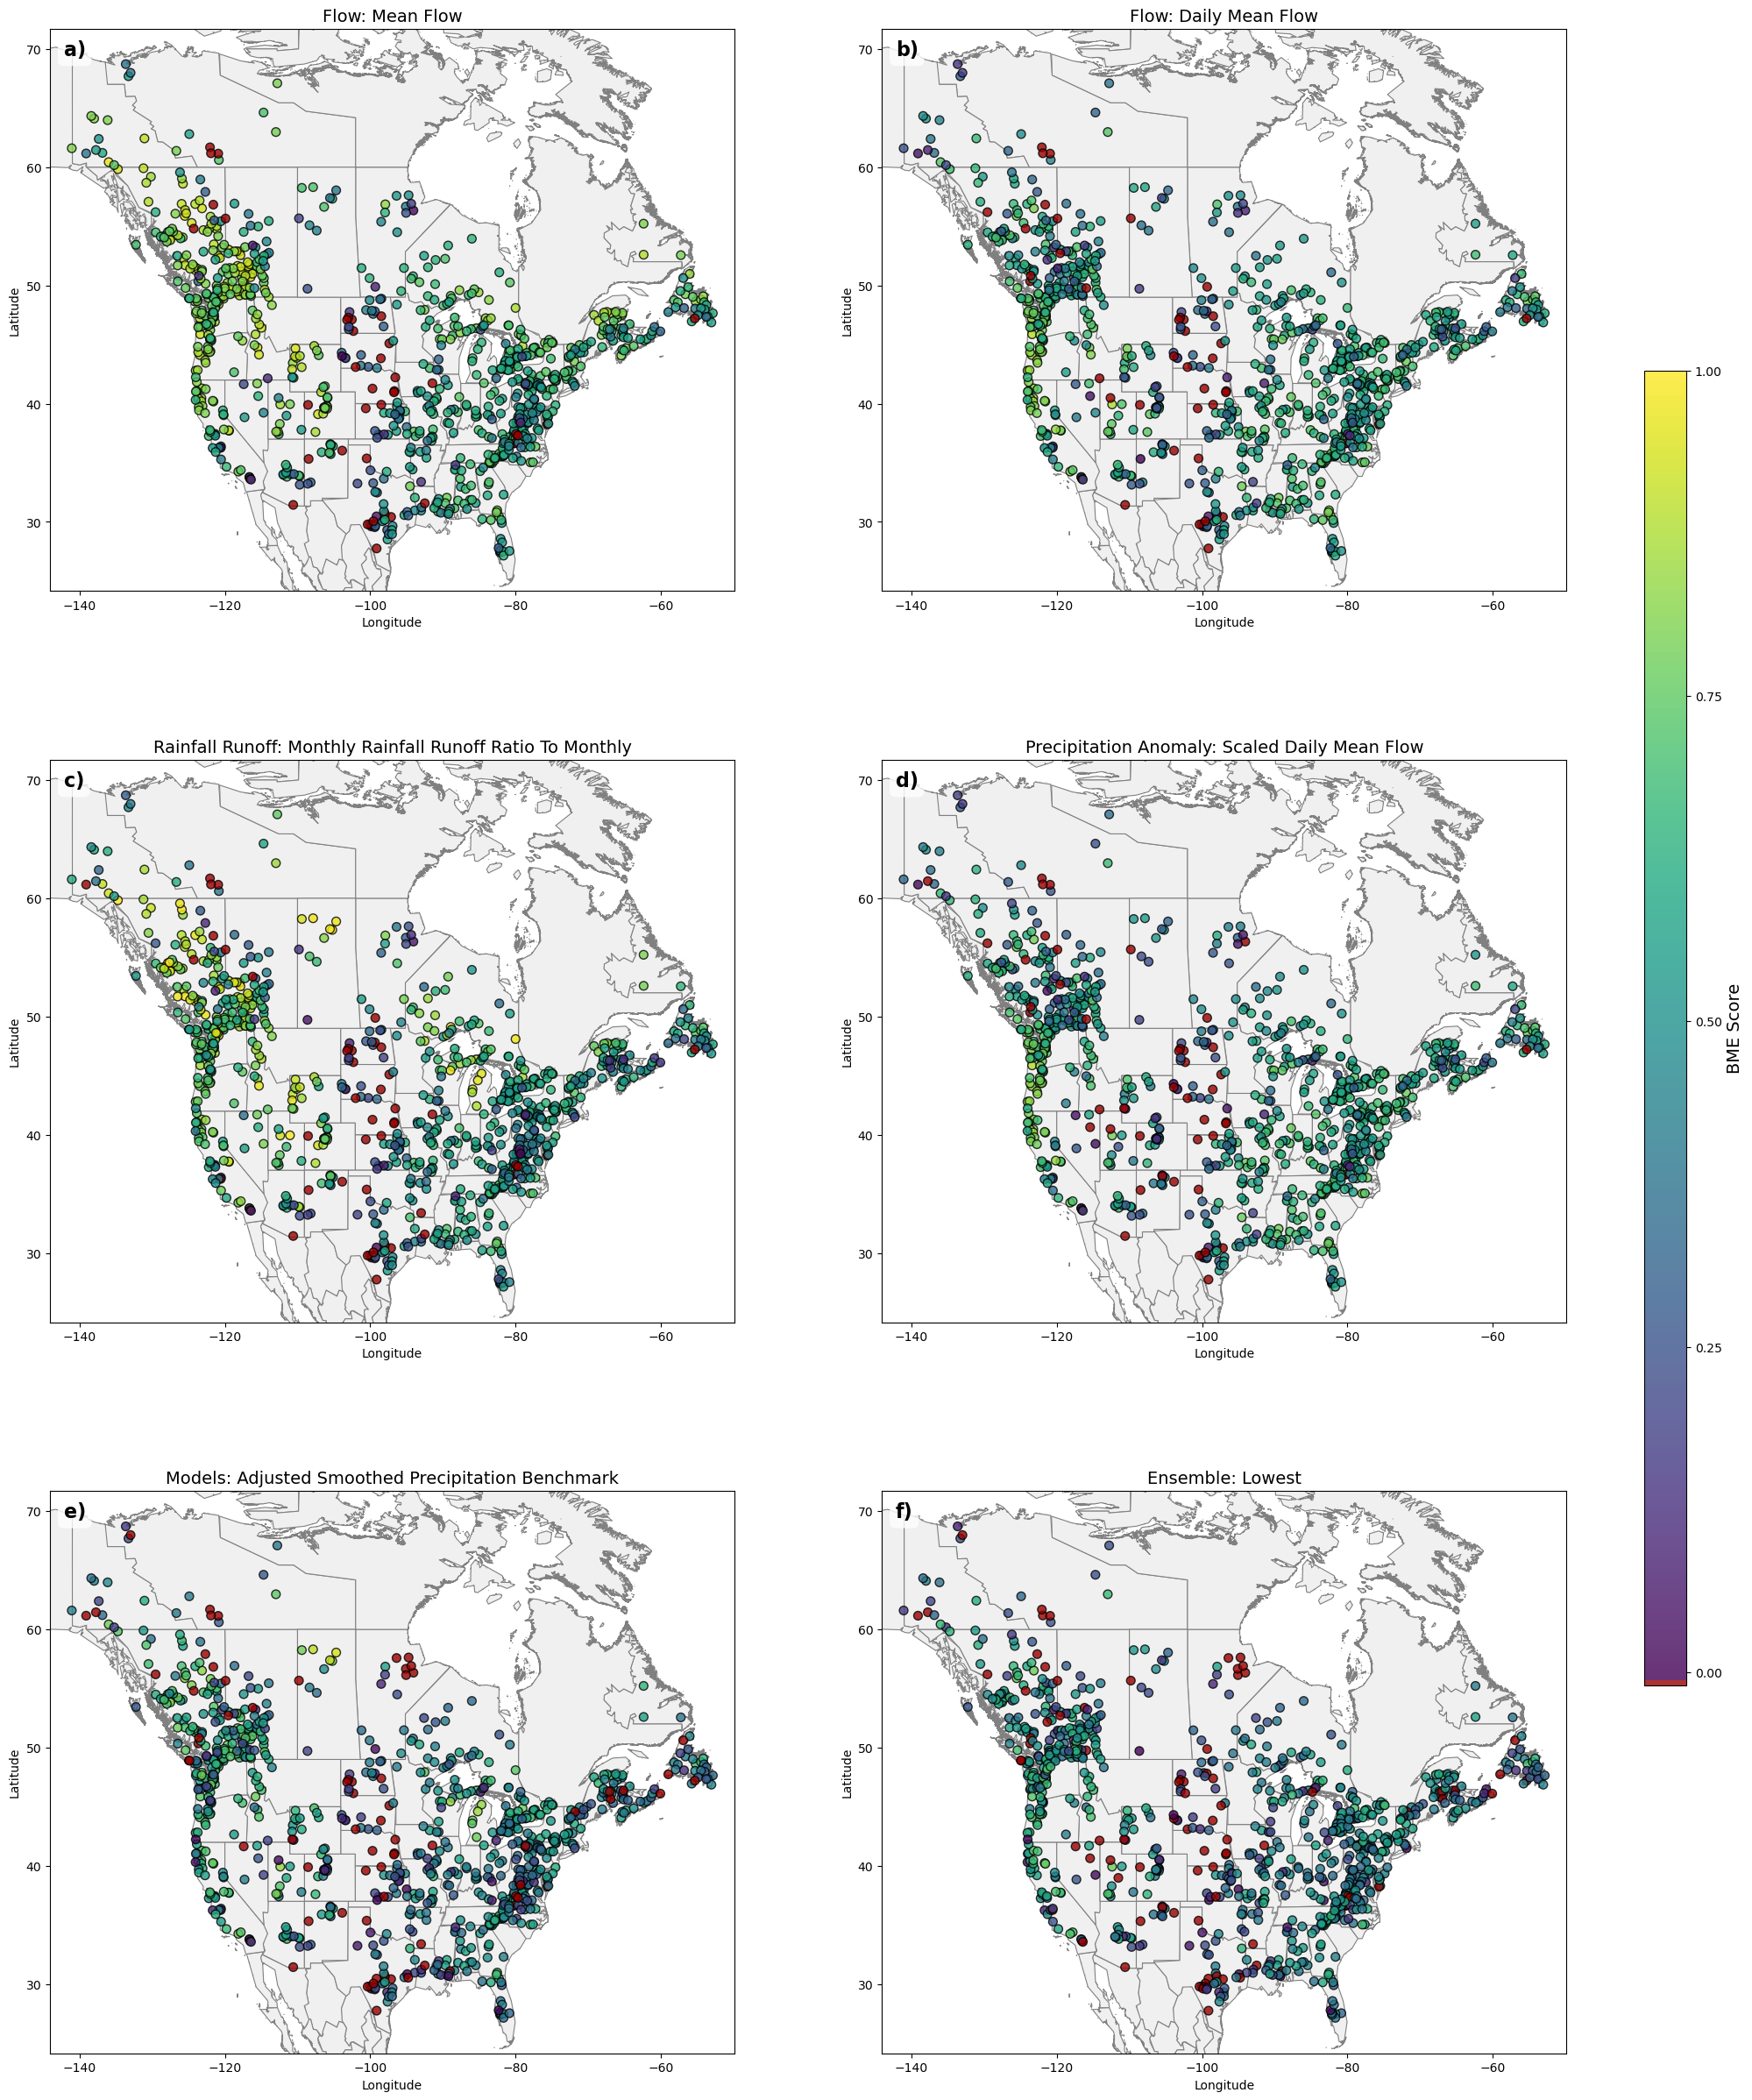

In [8]:
# --- Colormap setup
viridis = plt.cm.viridis
cmap_array = viridis(np.linspace(0, 1, 256))
neg_color = np.array([[0.6, 0, 0, 1]])  # dark red RGBA
cmap = ListedColormap(np.vstack([neg_color, cmap_array]))

# Grid layout
n_cols = 2
n_plots = len(plot_dfs)
n_rows = math.ceil(n_plots / n_cols)
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(12 * n_cols, 10 * n_rows)
)
axes = axes.flatten() if n_plots > 1 else [axes]

# Subplot labels
subplot_labels = [chr(97 + i) for i in range(n_plots)]  # a, b, c, ...

for idx, (ax, (benchmark, df_plot)) in enumerate(zip(axes, plot_dfs.items())):
    print(f'Plotting {benchmark}')
    
    # --- Format title with category prefix
    title = format_benchmark_name(benchmark)
    
    # --- Find extent of points
    lon_min, lon_max = df_plot['longitude'].min() - 3, df_plot['longitude'].max() + 3
    lat_min, lat_max = df_plot['latitude'].min() - 3, df_plot['latitude'].max() + 3
    
    # --- Trim borders shapefile to the points extent
    # Filter borders by points extent
    gdf_trim = gdf_borders[
        (gdf_borders.geometry.bounds.minx <= lon_max) &
        (gdf_borders.geometry.bounds.maxx >= lon_min) &
        (gdf_borders.geometry.bounds.miny <= lat_max) &
        (gdf_borders.geometry.bounds.maxy >= lat_min)
    ]
    
    # --- Plot the borders
    gdf_trim.plot(ax=ax, facecolor='#f0f0f0', edgecolor='grey', linewidth=0.8)
    
    # --- Scatter points
    colors = np.where(df_plot['skill_score'] < 0, -0.01, df_plot['skill_score'])
    sc = ax.scatter(
        df_plot['longitude'], df_plot['latitude'],
        c=colors,
        cmap=cmap,
        s=50,
        edgecolor='k',
        alpha=0.8,
        norm=Normalize(vmin=-0.01, vmax=1)
    )
    
    # --- Add subplot label
    ax.text(
        0.02, 0.98, f'{subplot_labels[idx]})',
        transform=ax.transAxes,
        fontsize=16,
        fontweight='bold',
        va='top',
        ha='left',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='none')
    )
    
    ax.set_title(title, fontsize=14)
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# Remove any empty axes
for ax in axes[n_plots:]:
    ax.set_visible(False)

# Adjust layout
plt.subplots_adjust(hspace=0.3, wspace=0.1, right=0.88)

# Colorbar
cbar_ax = fig.add_axes([0.90, 0.25, 0.02, 0.5])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('BME Score', fontsize=14)
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])

# --- Save figure
plt.savefig(f'{output_dir}/{plot_prefix}_spatial_bm.pdf', dpi=300)
plt.savefig(f'{output_dir}/{plot_prefix}_spatial_bm.png', dpi=300)
plt.show()

### Difference Between NSE and Lowest Benchmark

In [9]:
# Extract mean_flow rows
df_mean_flow = df_period[df_period['benchmark'] == 'bm_mean_flow'][[
    'catchment', 'latitude', 'longitude', 'skill_score'
]].rename(columns={'skill_score': 'mean_flow_score'})

# Extract lowest values from catchment_stats
df_low = catchment_stats[['catchment', 'lowest_value']]

# Merge
df_diff = df_mean_flow.merge(df_low, on='catchment', how='inner')

# Compute difference
df_diff['skill_diff'] = df_diff['mean_flow_score'] - df_diff['lowest_value']

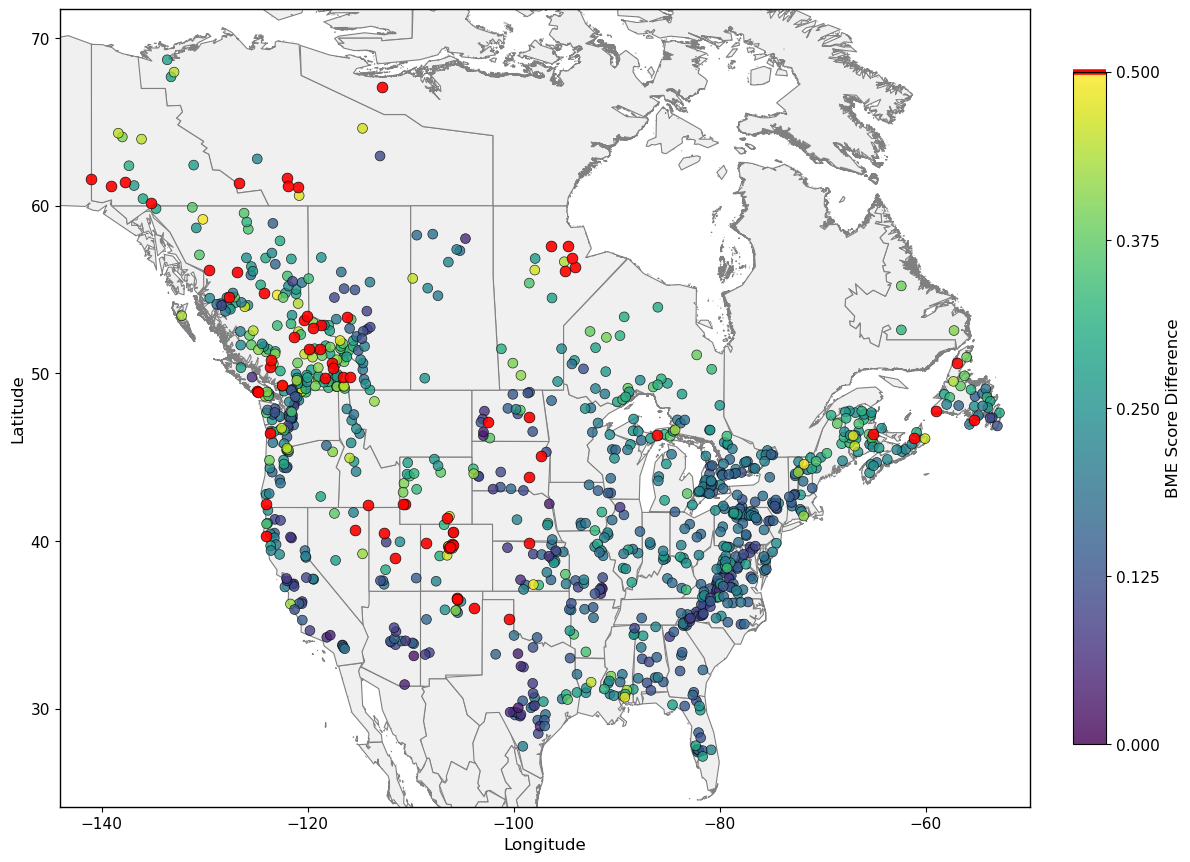

In [10]:
# --- Check if there's data
if df_diff.empty:
    print("⚠️ No overlapping catchments found between bm_mean_flow and lowest_value.")
else:
    # --- Trim extent with buffer (same method as subplot)
    lon_min, lon_max = df_diff['longitude'].min() - 3, df_diff['longitude'].max() + 3
    lat_min, lat_max = df_diff['latitude'].min() - 3, df_diff['latitude'].max() + 3
    
    # --- Filter borders shapefile to bbox
    gdf_trim = gdf_borders[
        (gdf_borders.geometry.bounds.minx <= lon_max) &
        (gdf_borders.geometry.bounds.maxx >= lon_min) &
        (gdf_borders.geometry.bounds.miny <= lat_max) &
        (gdf_borders.geometry.bounds.maxy >= lat_min)
    ]
    
    # --- Square figure (matching reference dimensions)
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # --- Plot trimmed borders (matching reference style)
    gdf_trim.plot(ax=ax, facecolor='#f0f0f0', edgecolor='grey', linewidth=0.8)
    
    # --- Set extent
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    
    # --- Scatter plot with colormap
    cmap = plt.cm.viridis
    vmin, vmax = 0, 0.5
    
    within_range = df_diff[df_diff['skill_diff'] <= vmax]
    above_range = df_diff[df_diff['skill_diff'] > vmax]
    
    sc = ax.scatter(
        within_range['longitude'], within_range['latitude'],
        c=within_range['skill_diff'],
        cmap=cmap,
        norm=Normalize(vmin=vmin, vmax=vmax),
        s=50,
        edgecolor='k',
        linewidths=0.5,
        alpha=0.8,
        zorder=3
    )
    
    if not above_range.empty:
        ax.scatter(
            above_range['longitude'], above_range['latitude'],
            color='red',
            s=60,
            edgecolor='k',
            linewidths=0.5,
            alpha=0.9,
            zorder=3
        )
    
    # --- Format axes (matching reference style)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.tick_params(labelsize=11)
    
    # No gridlines for cleaner look
    ax.grid(False)
    
    # Box around plot (matching reference)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.0)
        spine.set_edgecolor('black')
    
    # --- Add colorbar (positioned like reference, no title on top)
    cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, shrink=0.7)
    cbar.set_label('BME Score Difference', fontsize=12)
    cbar.set_ticks([0, 0.125, 0.25, 0.375, 0.5])
    cbar.ax.tick_params(labelsize=11)
    
    # Red indicator at top of colorbar
    if not above_range.empty:
        cbar.ax.plot([0, 1], [1, 1], color='red', linewidth=4, 
                     transform=cbar.ax.transAxes, clip_on=False, solid_capstyle='butt')
    
    plt.tight_layout()
    
    # --- Save + show
    plt.savefig(f'{output_dir}/{plot_prefix}_{period}_skill_diff_meanflow_lowest.png',
                dpi=300, bbox_inches='tight')
    plt.savefig(f'{output_dir}/{plot_prefix}_{period}_skill_diff_meanflow_lowest.pdf',
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

In [11]:
# Summary statistics for skill_diff
print("=" * 60)
print("SUMMARY STATISTICS FOR SKILL_DIFF")
print("=" * 60)

# Basic statistics
print("\nBasic Statistics:")
print(f"Count:    {df_diff['skill_diff'].count()}")
print(f"Mean:     {df_diff['skill_diff'].mean():.6f}")
print(f"Std Dev:  {df_diff['skill_diff'].std():.6f}")
print(f"Min:      {df_diff['skill_diff'].min():.6f}")
print(f"Max:      {df_diff['skill_diff'].max():.6f}")

# Percentiles
print("\nPercentiles:")
percentiles = [0, 1, 5, 10, 25, 50, 75, 90, 95, 99, 100]
for p in percentiles:
    value = df_diff['skill_diff'].quantile(p/100)
    print(f"  {p:3d}th percentile: {value:.6f}")

# Alternative: All percentiles from 0 to 100
print("\nAll Percentiles (0-100):")
all_percentiles = np.percentile(df_diff['skill_diff'].dropna(), range(0, 101))
for p, value in enumerate(all_percentiles):
    print(f"  {p:3d}th: {value:.6f}")

# Additional useful statistics
print("\nAdditional Statistics:")
print(f"Median (50th):     {df_diff['skill_diff'].median():.6f}")
print(f"IQR (75th - 25th): {df_diff['skill_diff'].quantile(0.75) - df_diff['skill_diff'].quantile(0.25):.6f}")
print(f"Negative values:   {(df_diff['skill_diff'] < 0).sum()} ({(df_diff['skill_diff'] < 0).sum() / len(df_diff) * 100:.1f}%)")
print(f"Zero values:       {(df_diff['skill_diff'] == 0).sum()}")
print(f"Positive values:   {(df_diff['skill_diff'] > 0).sum()} ({(df_diff['skill_diff'] > 0).sum() / len(df_diff) * 100:.1f}%)")

print("=" * 60)

SUMMARY STATISTICS FOR SKILL_DIFF

Basic Statistics:
Count:    960
Mean:     0.335412
Std Dev:  1.549066
Min:      0.031057
Max:      44.457737

Percentiles:
    0th percentile: 0.031057
    1th percentile: 0.053044
    5th percentile: 0.091969
   10th percentile: 0.112693
   25th percentile: 0.157174
   50th percentile: 0.218211
   75th percentile: 0.310216
   90th percentile: 0.446295
   95th percentile: 0.575924
   99th percentile: 1.169552
  100th percentile: 44.457737

All Percentiles (0-100):
    0th: 0.031057
    1th: 0.053044
    2th: 0.066788
    3th: 0.083290
    4th: 0.086559
    5th: 0.091969
    6th: 0.096236
    7th: 0.100365
    8th: 0.103735
    9th: 0.106572
   10th: 0.112693
   11th: 0.116213
   12th: 0.121384
   13th: 0.122947
   14th: 0.125664
   15th: 0.127113
   16th: 0.128726
   17th: 0.132559
   18th: 0.137058
   19th: 0.141008
   20th: 0.144468
   21th: 0.146065
   22th: 0.149535
   23th: 0.152533
   24th: 0.155197
   25th: 0.157174
   26th: 0.159038
   27th: 0

### CDF

In [12]:
# Prepare data for plotting
cdf_dfs = {}  # initialize dictionary
for benchmark in cdf_plots:
    if benchmark == 'highest':
        cdf_dfs[benchmark] = catchment_stats[['catchment','latitude','longitude','highest_value']].rename(columns={'highest_value':'skill_score'})
    elif benchmark == 'lowest':
        cdf_dfs[benchmark] = catchment_stats[['catchment','latitude','longitude','lowest_value']].rename(columns={'lowest_value':'skill_score'})
    else:
        cdf_dfs[benchmark] = df_period[df_period['benchmark'] == benchmark][['catchment','latitude','longitude','skill_score']]


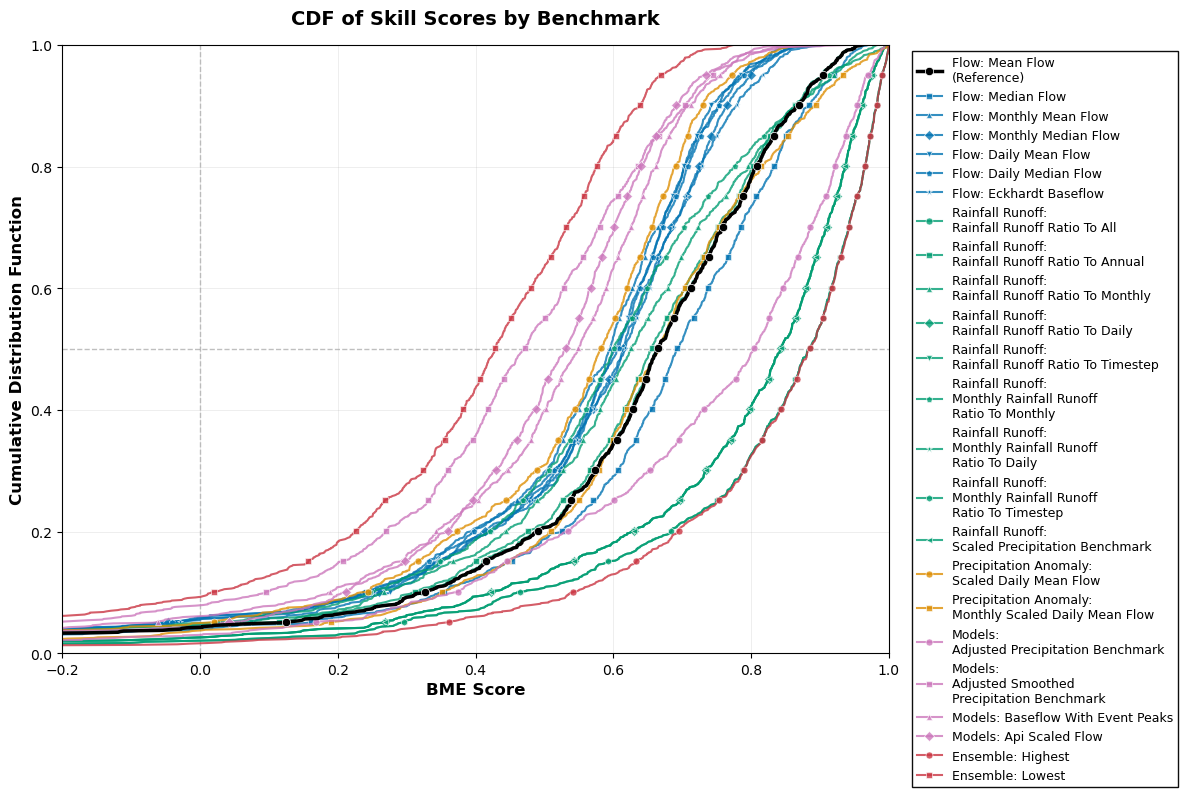

In [13]:
# Define categories
categories = {
    'Flow': [
        "bm_mean_flow", "bm_median_flow",
        "bm_monthly_mean_flow", "bm_monthly_median_flow",
        "bm_daily_mean_flow", "bm_daily_median_flow", "bm_eckhardt_baseflow"
    ],
    'Rainfall Runoff': [
        "bm_rainfall_runoff_ratio_to_all",
        "bm_rainfall_runoff_ratio_to_annual",
        "bm_rainfall_runoff_ratio_to_monthly",
        "bm_rainfall_runoff_ratio_to_daily",
        "bm_rainfall_runoff_ratio_to_timestep",
        "bm_monthly_rainfall_runoff_ratio_to_monthly",
        "bm_monthly_rainfall_runoff_ratio_to_daily",
        "bm_monthly_rainfall_runoff_ratio_to_timestep",
        "bm_scaled_precipitation_benchmark",
    ],
    'Precipitation Anomaly': [
        "bm_scaled_daily_mean_flow",
        "bm_monthly_scaled_daily_mean_flow",
    ],
    'Models': [
        "bm_adjusted_precipitation_benchmark",
        "bm_adjusted_smoothed_precipitation_benchmark",
        "bm_baseflow_with_event_peaks",
        "bm_api_scaled_flow",
    ],
    'Ensemble': ['highest', 'lowest']
}

# Improved color palette - more distinct and professional
# Using colorblind-friendly palette with better contrast
colors = {
    'Flow': '#0173B2',              # Deep blue
    'Rainfall Runoff': '#029E73',   # Teal/green
    'Precipitation Anomaly': '#DE8F05',  # Orange
    'Models': '#CC78BC',            # Purple/magenta
    'Ensemble': '#CA3542'           # Red
}

# Alternative option using seaborn palettes (uncomment to use)
# palette = sns.color_palette("colorblind", n_colors=5)
# colors = {
#     'Flow': palette[0],
#     'Rainfall Runoff': palette[1],
#     'Precipitation Anomaly': palette[2],
#     'Models': palette[3],
#     'Ensemble': palette[4]
# }

# Define a diverse set of markers
markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', '<', '>', 'X', 'P']

# Helper function to clean benchmark names with category prefix
def clean_label(name, category, max_length=35):
    """Clean benchmark name and add category prefix with line breaks for long names"""
    # Remove 'bm_' prefix
    name = name.replace("bm_", "")
    # Replace underscores with spaces
    name = name.replace("_", " ")
    # Capitalize each word
    name = name.title()
    
    # Add category prefix
    full_label = f"{category}: {name}"
    
    # Add line break if too long
    if len(full_label) > max_length:
        # Try to break after category prefix first
        full_label = f"{category}:\n{name}"
        
        # If still too long, break the name part intelligently
        if len(name) > max_length:
            words = name.split()
            mid_point = len(words) // 2
            line1 = " ".join(words[:mid_point])
            line2 = " ".join(words[mid_point:])
            full_label = f"{category}:\n{line1}\n{line2}"
    
    return full_label


# Create figure with better styling
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each category
for cat, benchmarks in categories.items():
    for i, benchmark in enumerate(benchmarks):
        if benchmark in cdf_dfs:
            scores = cdf_dfs[benchmark]['skill_score'].dropna().sort_values()
            cdf = np.arange(1, len(scores)+1) / len(scores)
            
            # Cycle markers
            marker = markers[i % len(markers)]
            
            # Highlight bm_mean_flow as reference benchmark
            if benchmark == 'bm_mean_flow':
                lw = 2.5
                alpha = 1.0
                linestyle = '-'
                zorder = 10
                color = 'black'
                markersize = 6
                label = "Flow: Mean Flow\n(Reference)"
            else:
                lw = 1.5
                alpha = 0.8
                linestyle = '-'
                zorder = 1
                color = colors[cat]
                markersize = 5
                label = clean_label(benchmark, cat)
            
            ax.plot(
                scores, cdf,
                label=label,
                color=color,
                marker=marker,
                markevery=max(1, len(scores)//20),
                alpha=alpha,
                linewidth=lw,
                linestyle=linestyle,
                zorder=zorder,
                markersize=markersize,
                markeredgewidth=0.5,
                markeredgecolor='white'
            )

# Styling improvements
ax.set_xlabel('BME Score', fontsize=12, weight='bold')
ax.set_ylabel('Cumulative Distribution Function', fontsize=12, weight='bold')
ax.set_title('CDF of Skill Scores by Benchmark', fontsize=14, weight='bold', pad=15)
ax.set_xlim(-0.2, 1)
ax.set_ylim(0, 1)

# Add reference lines
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5, zorder=0)
ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

# Grid styling
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Legend with category grouping
# Create custom legend with category headers
handles, labels = ax.get_legend_handles_labels()

# Sort by category
category_order = ['Flow', 'Rainfall Runoff', 'Precipitation Anomaly', 'Models', 'Ensemble']
sorted_handles = []
sorted_labels = []

for cat in category_order:
    # Find all benchmarks in this category
    cat_indices = []
    for i, label in enumerate(labels):
        # Check if this label belongs to current category
        # (by checking if it starts with category name)
        if label.startswith(cat + ":") or (cat == "Flow" and "Reference" in label):
            cat_indices.append(i)
    
    if cat_indices:
        # Add benchmarks from this category
        for idx in cat_indices:
            sorted_handles.append(handles[idx])
            sorted_labels.append(labels[idx])

# Create legend outside plot area with better formatting
legend = ax.legend(
    sorted_handles, sorted_labels,
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize=9,
    frameon=True,
    framealpha=0.95,
    edgecolor='black',
    fancybox=False,
    shadow=False,
    ncol=1
)
legend.get_frame().set_linewidth(1.0)

plt.tight_layout()

# Save figure
plt.savefig(f'{output_dir}/{plot_prefix}_{period}_cdf.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{output_dir}/{plot_prefix}_{period}_cdf.pdf', dpi=300, bbox_inches='tight')
plt.show()


### Statistics

In [14]:
# 1. Per-benchmark stats
stats_df = pd.DataFrame(columns=['benchmark','mean','median','std','iqr','min','max'])
for benchmark, df in cdf_dfs.items():
    scores = df['skill_score'].dropna()
    stats_df = pd.concat([
        stats_df,
        pd.DataFrame([{
            'benchmark': benchmark,
            'mean': scores.mean(),
            'median': scores.median(),
            'std': scores.std(),
            'iqr': scores.quantile(0.75) - scores.quantile(0.25),
            'min': scores.min(),
            'max': scores.max()
        }])
    ], ignore_index=True)

# 2. Per-group stats
group_stats = pd.DataFrame(columns=['group','mean','median','std','iqr','min','max'])
for group, benchmarks in categories.items():
    # collect all scores in this group
    all_scores = pd.concat([cdf_dfs[b]['skill_score'].dropna() for b in benchmarks if b in cdf_dfs])
    if len(all_scores) > 0:
        group_stats = pd.concat([
            group_stats,
            pd.DataFrame([{
                'group': group,
                'mean': all_scores.mean(),
                'median': all_scores.median(),
                'std': all_scores.std(),
                'iqr': all_scores.quantile(0.75) - all_scores.quantile(0.25),
                'min': all_scores.min(),
                'max': all_scores.max()
            }])
        ], ignore_index=True)



/tmp/ipykernel_1066107/3254197652.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats_df = pd.concat([
/tmp/ipykernel_1066107/3254197652.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  group_stats = pd.concat([


In [15]:
# Ensure highest and lowest exist
if 'highest' in plot_dfs and 'lowest' in plot_dfs:
    # Get scores
    high_scores = plot_dfs['highest']['skill_score'].dropna().sort_values()
    low_scores = plot_dfs['lowest']['skill_score'].dropna().sort_values()
    
    # Compute CDFs
    high_cdf = np.arange(1, len(high_scores)+1) / len(high_scores)
    low_cdf = np.arange(1, len(low_scores)+1) / len(low_scores)
    
    # Find CDF value at skill_score = 0
    # Use searchsorted to find the index where score >= 0
    idx_high = np.searchsorted(high_scores, 0)
    idx_low = np.searchsorted(low_scores, 0)
    
    # Probability that score <= 0
    prob_high = high_cdf[idx_high] if idx_high < len(high_cdf) else 1.0
    prob_low = low_cdf[idx_low] if idx_low < len(low_cdf) else 1.0
    
    diff_prob = prob_high - prob_low
    
    print(f"Probability (skill <= 0) for 'highest': {prob_high:.2f}")
    print(f"Probability (skill <= 0) for 'lowest': {prob_low:.2f}")
    print(f"Difference in probability: {diff_prob:.2f}")
else:
    print("Highest or lowest benchmark missing in plot_dfs")

Highest or lowest benchmark missing in plot_dfs


In [16]:

# Filter to remove NaN skill scores
df_valid = df_period.dropna(subset=['skill_score']).copy()

# Find the benchmark with the minimum skill score per catchment
lowest_per_catchment = df_valid.loc[df_valid.groupby('catchment')['skill_score'].idxmin()]

# Count how many times each benchmark is the lowest
lowest_counts = lowest_per_catchment['benchmark'].value_counts().sort_values(ascending=False)

# Convert to DataFrame
lowest_counts_df = lowest_counts.reset_index()
lowest_counts_df.columns = ['benchmark', 'count']

# Apply formatting: remove 'bm_' prefix, replace '_' with space, capitalize words
lowest_counts_df['benchmark'] = (
    lowest_counts_df['benchmark']
    .str.replace(r'^bm_', '', regex=True)  # remove 'bm_' prefix
    .str.replace('_', ' ')                  # replace underscores with spaces
    .str.title()                            # capitalize first letter of each word
)

In [17]:
# Filter to remove NaN skill scores
df_valid = df_period.dropna(subset=['skill_score']).copy()

# Find the benchmark with the minimum skill score per catchment
lowest_per_catchment = df_valid.loc[df_valid.groupby('catchment')['skill_score'].idxmin()]

# Count how many times each benchmark is the lowest
lowest_counts = lowest_per_catchment['benchmark'].value_counts().sort_values(ascending=False)

# Convert to DataFrame
lowest_counts_df = lowest_counts.reset_index()
lowest_counts_df.columns = ['benchmark', 'count']

# Count negative skill scores for each benchmark
negative_counts = (
    df_valid[df_valid['skill_score'] < 0]
    .groupby('benchmark')
    .size()
    .reset_index(name='negative_count')
)

# Merge the negative counts with the lowest counts
lowest_counts_df = lowest_counts_df.merge(
    negative_counts,
    on='benchmark',
    how='left'
)

# Fill NaN with 0 (benchmarks that never had negative skill scores)
lowest_counts_df['negative_count'] = lowest_counts_df['negative_count'].fillna(0).astype(int)

# Apply formatting: remove 'bm_' prefix, replace '_' with space, capitalize words
lowest_counts_df['benchmark'] = (
    lowest_counts_df['benchmark']
    .str.replace(r'^bm_', '', regex=True)  # remove 'bm_' prefix
    .str.replace('_', ' ')                  # replace underscores with spaces
    .str.title()                            # capitalize first letter of each word
)